### Project 5th With Sampled Data

Project ini adalah eksperimen tambahan sesuai dengan masukan dan saran dari ketua penguji seminar hasil, dimana data dilakukan sampling terlebih dahulu menjadi 700x700 kemudian di augmentasi untuk mengetahui perbedaannya

### Import Library

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import os
import cv2
import shutil
import random

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Conv2D, MaxPooling2D,Flatten, Dropout, BatchNormalization, Activation, Add, GlobalAveragePooling2D
from keras.models import Model
from keras.activations import relu
from keras.backend import softmax
from keras.optimizers import Adam
from keras.regularizers import l1, l2, l1_l2
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.utils import img_to_array, array_to_img
from keras.utils.image_utils import load_img

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split

### Sampling The Data + Profilling

In [3]:
data = pd.read_csv('/Calvino/TA/trainLabels.csv')
data.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [4]:
# sampling the data

df = pd.DataFrame(data)
sampled_df = df.groupby('level').sample(700)
sampled_df

,image,level
1462,1831_left,0
27997,35457_right,0
16431,20583_right,0
30100,38096_left,0
9337,11754_right,0
...,...,...
15448,19347_left,4
30080,38064_left,4
18597,23433_right,4
19038,24019_left,4


In [5]:
final_df = pd.DataFrame(sampled_df)

final_df['filename'] = sampled_df['image'].apply(lambda x : x + '.jpeg')
final_df['path'] = sampled_df['image'].apply(lambda x : 'train/' + x + '.jpeg')
final_df['patient_id'] = sampled_df['image'].apply(lambda x : x.split('_')[0])
final_df['eye_side'] = sampled_df['image'].apply(lambda x : x.split('_')[1])
final_df['level'] = sampled_df['level']
final_df

,image,level,filename,path,patient_id,eye_side
1462,1831_left,0,1831_left.jpeg,train/1831_left.jpeg,1831,left
27997,35457_right,0,35457_right.jpeg,train/35457_right.jpeg,35457,right
16431,20583_right,0,20583_right.jpeg,train/20583_right.jpeg,20583,right
30100,38096_left,0,38096_left.jpeg,train/38096_left.jpeg,38096,left
9337,11754_right,0,11754_right.jpeg,train/11754_right.jpeg,11754,right
...,...,...,...,...,...,...
15448,19347_left,4,19347_left.jpeg,train/19347_left.jpeg,19347,left
30080,38064_left,4,38064_left.jpeg,train/38064_left.jpeg,38064,left
18597,23433_right,4,23433_right.jpeg,train/23433_right.jpeg,23433,right
19038,24019_left,4,24019_left.jpeg,train/24019_left.jpeg,24019,left


In [6]:
# untuk mengetahui persebaran data
final_df['level'].value_counts().sort_values(ascending=False)

0    700
1    700
2    700
3    700
4    700
Name: level, dtype: int64

In [7]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2,y[i], ha='center')

labels = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

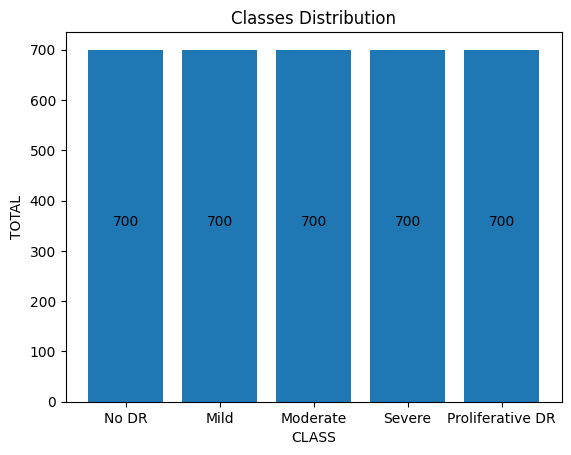

In [8]:
# visualize classes distribution
num_classes = len(np.unique(final_df['level']))
# class_dist = [len(final_df.loc[sampled_df['level'] == x]) for x in range(num_classes)]
class_dist = final_df['level'].value_counts().sort_values(ascending=False)
plt.title('Classes Distribution')
plt.xlabel('CLASS')
plt.ylabel('TOTAL')
plt.bar(labels, class_dist)
addlabels(class_dist, final_df['level'].value_counts())

### Split The Data

In [9]:
x = final_df.drop('level', axis=1) # axis 1 = column
y = final_df['level']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Further split the train set into train and validation sets
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Print the shapes of the resulting sets
print("Train set shape:", X_train2.shape, y_train2.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (2100, 5) (2100,)
Validation set shape: (700, 5) (700,)
Test set shape: (700, 5) (700,)


### Insert Image Into The Corresponding Directory

In [10]:
# def makedirs (mode) :
#   # Set up the directory structure
#   categories = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']
#   data_categories = ['train', 'val', 'test']
#   target_directory = '/Calvino/TA/models/5th_sampling/new_data/' 
#   src_path = '/AiDiTech/Penelitian Kak Guntur/train/train/'

#   if not os.path.exists(target_directory) :
#     # Make a directories
#     for data in data_categories :
#       new_dir = os.path.join(target_directory, data)
#       os.makedirs(new_dir, exist_ok=True)

#       for category in categories :
#         category_dir = os.path.join(new_dir, category)
#         os.makedirs(category_dir, exist_ok=True)

#   # Save the image into new directory
#   if mode=='train' :
#     print("INSERTING TRAIN IMAGE.........")
#     train_path = '/Calvino/TA/models/5th_sampling/new_data/train'
    
#     for image_file in X_train2['path']:
#       lvl = int(y_train2[X_train2['path']==image_file])
      
#       if os.path.exists(src_path + image_file.split('/')[1]):
#         if lvl == 0 :
#           shutil.copy(src_path + image_file.split('/')[1], train_path + '/' + categories[0] + '/' + image_file.split('/')[1])
#         elif lvl == 1 :
#           shutil.copy(src_path + image_file.split('/')[1], train_path + '/' + categories[1] + '/' + image_file.split('/')[1])
#         elif lvl == 2 :
#           shutil.copy(src_path + image_file.split('/')[1], train_path + '/' + categories[2] + '/' + image_file.split('/')[1])
#         elif lvl == 3 :
#           shutil.copy(src_path + image_file.split('/')[1], train_path + '/' + categories[3] + '/' + image_file.split('/')[1])
#         elif lvl == 4 :
#           shutil.copy(src_path + image_file.split('/')[1], train_path + '/' + categories[4] + '/' + image_file.split('/')[1])
#       else :
#         print("image not found")        
#     print("INSERTING DONE! \n")

#   elif mode=='valid' :
#     print("INSERTING VALIDATION IMAGE.........")
#     val_path = '/Calvino/TA/models/5th_sampling/new_data/val'
    
#     for image_file in X_val['path']:
#       lvl = int(y_val[X_val['path']==image_file])

#       if os.path.exists(src_path + image_file.split('/')[1]):
#         if lvl == 0 :
#           shutil.copy(src_path + image_file.split('/')[1], val_path + '/' + categories[0] + '/' + image_file.split('/')[1])
#         elif lvl == 1 :
#           shutil.copy(src_path + image_file.split('/')[1], val_path + '/' + categories[1] + '/' + image_file.split('/')[1])
#         elif lvl == 2 :
#           shutil.copy(src_path + image_file.split('/')[1], val_path + '/' + categories[2] + '/' + image_file.split('/')[1])
#         elif lvl == 3 :
#           shutil.copy(src_path + image_file.split('/')[1], val_path + '/' + categories[3] + '/' + image_file.split('/')[1])
#         elif lvl == 4 :
#           shutil.copy(src_path + image_file.split('/')[1], val_path + '/' + categories[4] + '/' + image_file.split('/')[1])
#       else :
#         print("image not found")
#     print("INSERTING DONE! \n")

#   elif mode=='test' :
#     print("INSERTING TEST IMAGE.........")
#     test_path = '/Calvino/TA/models/5th_sampling/new_data/test'
    
#     for image_file in X_test['path']:
#       lvl = int(y_test[X_test['path']==image_file])

#       if os.path.exists(src_path + image_file.split('/')[1]):
#         if lvl == 0 :
#           shutil.copy(src_path + image_file.split('/')[1], test_path + '/' + categories[0] + '/' + image_file.split('/')[1])
#         elif lvl == 1 :
#           shutil.copy(src_path + image_file.split('/')[1], test_path + '/' + categories[1] + '/' + image_file.split('/')[1])
#         elif lvl == 2 :
#           shutil.copy(src_path + image_file.split('/')[1], test_path + '/' + categories[2] + '/' + image_file.split('/')[1])
#         elif lvl == 3 :
#           shutil.copy(src_path + image_file.split('/')[1], test_path + '/' + categories[3] + '/' + image_file.split('/')[1])
#         elif lvl == 4 :
#           shutil.copy(src_path + image_file.split('/')[1], test_path + '/' + categories[4] + '/' + image_file.split('/')[1])
#       else :
#         print("image not found")
#     print("INSERTING DONE! \n")
      

In [11]:
# makedirs('train')
# makedirs('valid')
# makedirs('test')

### Augmentation

In [14]:
# categories = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']
# data_categories = ['augmented_train']
# target_directory = '/Calvino/TA/models/5th_sampling/new_data/'

# for data in data_categories :
#   new_dir = os.path.join(target_directory, data)
#   os.makedirs(new_dir, exist_ok=True)

#   for category in categories :
#     category_dir = os.path.join(new_dir, category)
#     os.makedirs(category_dir, exist_ok=True)

In [15]:
input_dir = '/Calvino/TA/models/5th_sampling/new_data/train'
output_dir = '/Calvino/TA/models/5th_sampling/new_data/augmented_train'

In [16]:
def add_gaussian_noise(image, mean, std):
    noise = np.random.normal(mean, std, image.shape)
    noisy_image = np.clip(image + noise, 0, 255).astype(np.uint8) # utk membatasi array agar memiliki range 0 - 255
    return noisy_image

In [17]:
folder = os.listdir(input_dir)

for cat in folder :
  cat_dir = os.path.join(input_dir, cat)

  for filename in os.listdir(cat_dir):
    image = load_img(os.path.join(cat_dir, filename))
    arr_img = img_to_array(image)

    # Expand dimensions to match the expected shape for augmentation
    x = arr_img.reshape((1,) + arr_img.shape)

    # Generator
    bright_up_gen = ImageDataGenerator(brightness_range=[1.2, 1.8]) # random change the brightness with min value = 120% and max value = 180% than the og img
    bright_down_gen = ImageDataGenerator(brightness_range=[0.2, 0.5])
    contrast_gen = ImageDataGenerator(channel_shift_range=100)
   
    brighted_up_images = bright_up_gen.flow(x, batch_size=1,
                                      save_to_dir=os.path.join(output_dir, cat),
                                      save_prefix='aug_brightness-up_' + filename.split('.jpeg')[0],
                                      save_format='jpeg')
    brighted_down_images = bright_down_gen.flow(x, batch_size=1,
                                      save_to_dir=os.path.join(output_dir, cat),
                                      save_prefix='aug_brightness-down_' + filename.split('.jpeg')[0],
                                      save_format='jpeg')
    contrasted_images = contrast_gen.flow(x, batch_size=1,
                                          save_to_dir=os.path.join(output_dir, cat),
                                          save_prefix='aug_contrast_' + filename.split('.jpeg')[0],
                                          save_format='jpeg')

    contrasted_image = contrasted_images.next()
    brighted_up_image = brighted_up_images.next()
    brighted_down_image = brighted_down_images.next()

    # NOISE ADDING
    noisy_image = add_gaussian_noise(arr_img, 0, 150) # mean = 0, stddev = 150
    noisy_image_pil = array_to_img(noisy_image)
    noisy_image_pil.save(os.path.join(output_dir, cat) + '/aug_noise_' + filename)

### Image Data Generator

In [18]:
train_path = '/Calvino/TA/models/5th_sampling/new_data/train'
valid_path = '/Calvino/TA/models/5th_sampling/new_data/val'
test_path = '/Calvino/TA/models/5th_sampling/new_data/test'
aug_path = '/Calvino/TA/models/5th_sampling/new_data/augmented_train'

In [20]:
image_size = (224, 224)
batch_size = 16

datagen = ImageDataGenerator(
    rescale=1./255 # Normalize pixel values to [0, 1]
)

train_generator = datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

valid_generator = datagen.flow_from_directory(
    valid_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

aug_generator = datagen.flow_from_directory(
    aug_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 2100 images belonging to 5 classes.
Found 700 images belonging to 5 classes.
Found 700 images belonging to 5 classes.
Found 10500 images belonging to 5 classes.


### Development Phase

In [21]:
input_shape = train_generator.image_shape

lr = 0.0001
steps_per_epoch = 50
epochs = 30
validation_steps = 30

In [22]:
def show_accuracy(history, model, reg):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(model + ' ' + reg + ' Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
def show_loss(history, model, reg):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(model + ' ' + reg + ' Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

#### VGG16

In [23]:
def VGG16 (input_shape) :

    x_input = Input(input_shape, name="input_layer") #VGG16 input_shape by default is (64,64,1)

    #FEATURE EXTRACTION - Convolutional Layers
    x = Conv2D(64, (3,3), padding="same", activation=relu, name="block1_conv1")(x_input)
    x = Conv2D(64, (3,3), padding="same", activation=relu, name="block1_conv2")(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block1_maxpool")(x)

    x = Conv2D(128, (3,3), padding="same", activation=relu, name="block2_conv1")(x)
    x = Conv2D(128, (3,3), padding="same", activation=relu, name="block2_conv2")(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block2_maxpool")(x)

    x = Conv2D(256, (3,3), padding="same", activation=relu, name="block3_conv1")(x)
    x = Conv2D(256, (3,3), padding="same", activation=relu, name="block3_conv2")(x)
    x = Conv2D(256, (3,3), padding="same", activation=relu, name="block3_conv3")(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block3_maxpool")(x)

    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block4_conv1")(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block4_conv2")(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block4_conv3")(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block4_pool")(x)

    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block5_conv1")(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block5_conv2")(x)
    x = Conv2D(512, (3,3), padding="same", activation=relu, name="block5_conv3")(x)
    x = MaxPooling2D((2,2), strides=(2,2), name="block5_pool")(x)

    #Make it into 1 dimension
    x = Flatten()(x)

    #CLASSIFICATION - Fully Connected Layers
    x = Dense(4096, activation=relu, name="fc1")(x) #1
    x = Dense(4096, activation=relu, name="fc2")(x) #2
    x = Dense(5, activation=softmax, name="predictions")(x) #3
    #n_class = number of output label

    model = Model(inputs = x_input, outputs = x, name = "VGG16")

    return model

In [24]:
model_VGG = VGG16(input_shape)
model_VGG.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=lr),
                metrics=['accuracy'])

In [18]:
history_VGG = model_VGG.fit(
      train_generator,
      steps_per_epoch = steps_per_epoch,
      epochs = epochs,
      validation_data = valid_generator,
      validation_steps = validation_steps,
      verbose=1)

Epoch 1/30
50/50 [==============================] - 643s 13s/step - loss: 1.6115 - accuracy: 0.2138 - val_loss: 1.6096 - val_accuracy: 0.1854
Epoch 2/30
50/50 [==============================] - 1024s 21s/step - loss: 1.6098 - accuracy: 0.1988 - val_loss: 1.6095 - val_accuracy: 0.1958
Epoch 3/30
50/50 [==============================] - 535s 10s/step - loss: 1.6088 - accuracy: 0.1992 - val_loss: 1.6111 - val_accuracy: 0.2021
Epoch 4/30
50/50 [==============================] - 374s 7s/step - loss: 1.6082 - accuracy: 0.2259 - val_loss: 1.6110 - val_accuracy: 0.2250
Epoch 5/30
50/50 [==============================] - 495s 8s/step - loss: 1.6093 - accuracy: 0.2062 - val_loss: 1.6098 - val_accuracy: 0.2021
Epoch 6/30
50/50 [==============================] - 447s 8s/step - loss: 1.6091 - accuracy: 0.2138 - val_loss: 1.6119 - val_accuracy: 0.1896
Epoch 7/30
50/50 [==============================] - 408s 7s/step - loss: 1.6052 - accuracy: 0.2183 - val_loss: 1.6180 - val_accuracy: 0.1937
Epoch 8/3

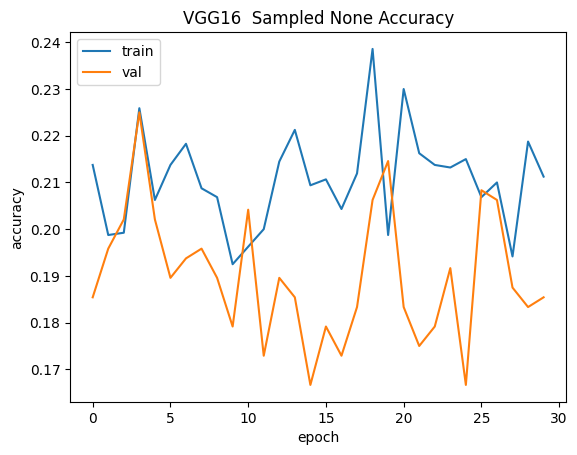

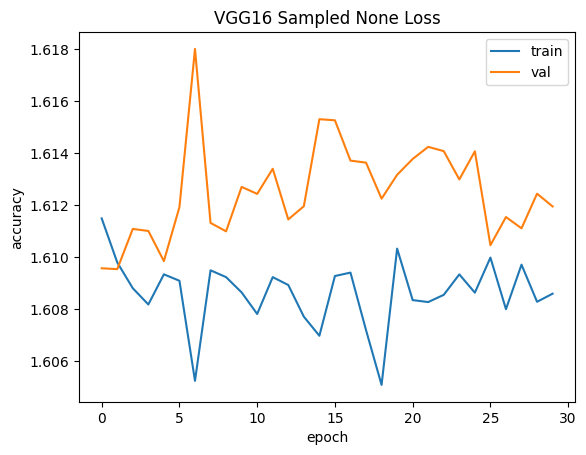

In [24]:
show_accuracy(history_VGG, "VGG16", " Sampled None")
show_loss(history_VGG, "VGG16", "Sampled None")

In [23]:
vgg_loss, vgg_acc = history_VGG.model.evaluate(train_generator)
print(vgg_loss)
print(vgg_acc)

132/132 [==============================] - 137s 1s/step - loss: 1.6084 - accuracy: 0.2114
1.6083701848983765
0.21142856776714325


In [22]:
vgg_loss, vgg_acc = history_VGG.model.evaluate(test_generator)
print(vgg_loss)
print(vgg_acc)

44/44 [==============================] - 40s 895ms/step - loss: 1.6147 - accuracy: 0.1714
1.6146550178527832
0.17142857611179352


In [20]:
y_pred = history_VGG.model.predict(test_generator)
y_pred_class = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

cr = classification_report(y_true, y_pred_class)
print(cr)

44/44 [==============================] - 34s 756ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       138
           1       0.00      0.00      0.00       138
           2       0.00      0.00      0.00       167
           3       0.00      0.00      0.00       137
           4       0.17      1.00      0.29       120

    accuracy                           0.17       700
   macro avg       0.03      0.20      0.06       700
weighted avg       0.03      0.17      0.05       700



c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

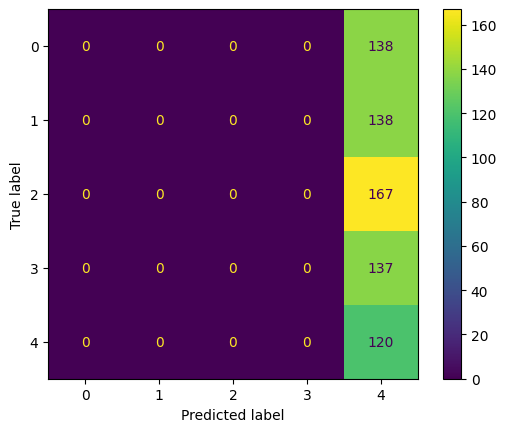

In [21]:
cm = confusion_matrix(y_true, y_pred_class)
cm_display = ConfusionMatrixDisplay(cm)

cm_display.plot()
plt.show()

#### VGG16 w/ Aug

In [29]:
history_VGG_aug = model_VGG.fit(
      aug_generator,
      steps_per_epoch = steps_per_epoch,
      epochs = 30,
      validation_data = valid_generator,
      validation_steps = validation_steps,
      verbose=1)

Epoch 1/30
50/50 [==============================] - 193s 4s/step - loss: 1.6067 - accuracy: 0.2362 - val_loss: 1.6199 - val_accuracy: 0.2062
Epoch 2/30
50/50 [==============================] - 897s 18s/step - loss: 1.6100 - accuracy: 0.1975 - val_loss: 1.6098 - val_accuracy: 0.2000
Epoch 3/30
50/50 [==============================] - 1085s 22s/step - loss: 1.6101 - accuracy: 0.2100 - val_loss: 1.6097 - val_accuracy: 0.1833
Epoch 4/30
50/50 [==============================] - 1009s 20s/step - loss: 1.6088 - accuracy: 0.2113 - val_loss: 1.6093 - val_accuracy: 0.2021
Epoch 5/30
50/50 [==============================] - 573s 11s/step - loss: 1.6101 - accuracy: 0.1762 - val_loss: 1.6102 - val_accuracy: 0.1917
Epoch 6/30
50/50 [==============================] - 298s 6s/step - loss: 1.6070 - accuracy: 0.2050 - val_loss: 1.6172 - val_accuracy: 0.2000
Epoch 7/30
50/50 [==============================] - 303s 6s/step - loss: 1.6092 - accuracy: 0.2262 - val_loss: 1.6128 - val_accuracy: 0.1667
Epoch 8

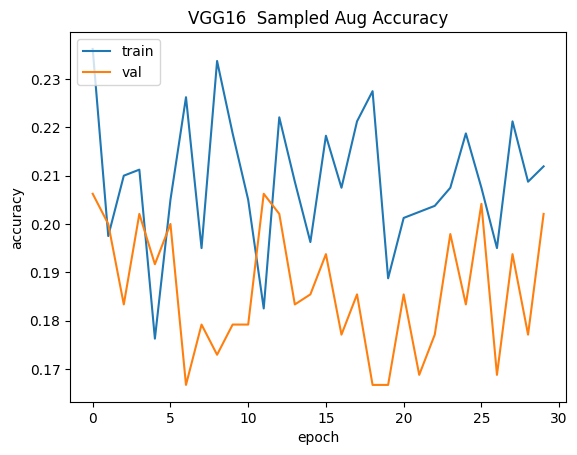

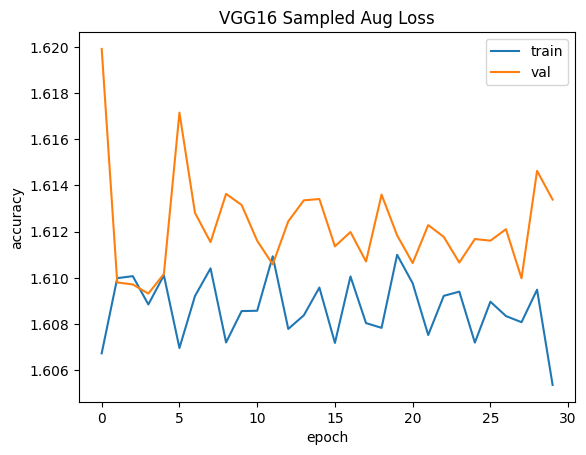

In [30]:
show_accuracy(history_VGG_aug, "VGG16", " Sampled Aug")
show_loss(history_VGG_aug, "VGG16", "Sampled Aug")

In [31]:
vgg_loss, vgg_acc = history_VGG_aug.model.evaluate(aug_generator)
print(vgg_loss)
print(vgg_acc)

657/657 [==============================] - 3270s 5s/step - loss: 1.6085 - accuracy: 0.2114
1.6084588766098022
0.21142856776714325


In [32]:
vgg_loss, vgg_acc = history_VGG_aug.model.evaluate(test_generator)
print(vgg_loss)
print(vgg_acc)

44/44 [==============================] - 166s 4s/step - loss: 1.6159 - accuracy: 0.1714
1.6159204244613647
0.17142857611179352


In [33]:
y_pred = history_VGG_aug.model.predict(test_generator)
y_pred_class = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

cr = classification_report(y_true, y_pred_class)
print(cr)

44/44 [==============================] - 165s 4s/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       138
           1       0.00      0.00      0.00       138
           2       0.00      0.00      0.00       167
           3       0.00      0.00      0.00       137
           4       0.17      1.00      0.29       120

    accuracy                           0.17       700
   macro avg       0.03      0.20      0.06       700
weighted avg       0.03      0.17      0.05       700



c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

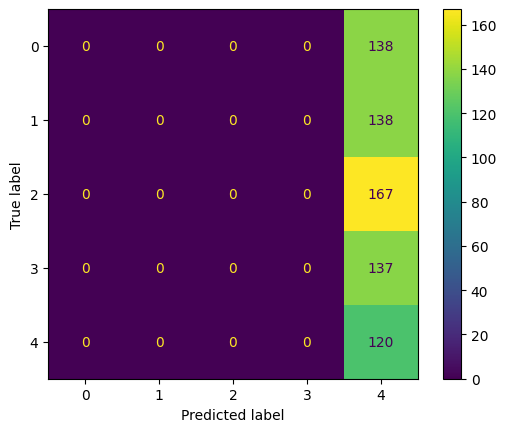

In [34]:
cm = confusion_matrix(y_true, y_pred_class)
cm_display = ConfusionMatrixDisplay(cm)

cm_display.plot()
plt.show()